In [107]:
#import all libraries
import numpy as np
import pandas as pd
import seaborn as sns
import eli5

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

#scikit-learn
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model
from pprint import pprint

#### Read in data for airbnb
***

In [108]:
data = pd.read_csv('airbnb_final_dataset.csv')

#### Split data into 60% train, 20% validation, and 20% test sets

In [109]:
X = data.drop(['price'], axis=1)
y = data['price']
np.random.seed(123)
X, X_test, y, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

#### First train a linear regression model with all the features

In [27]:
lin_model = LinearRegression().fit(X_train, y_train)
lin_pred_train = lin_model.predict(X_train)
lin_pred_val = lin_model.predict(X_val)
print('R2 Train: ' + str(lin_model.score(X_train, y_train)))
print('R2 Val: ' + str(lin_model.score(X_val, y_val)))
print('Train MAE: ' + str(mean_absolute_error(y_train, lin_pred_train)))
print('Val MAE: ' + str(mean_absolute_error(y_val, lin_pred_val)))

R2 Train: 0.6387992188415805
R2 Val: 0.470239618895083
Train MAE: 87.71939506386633
Val MAE: 90.96476679366543


Our R2 value was not great and our MAE was quite high

#### Next, we tried using lasso regression to see if our R2 and MAE would improve
***

We ran cross validation to find the best alpha value for lasso_cv then fit our model

In [22]:
lasso_cv = LassoCV(alphas=np.arange(.001, 5, .001), cv = 3)
lasso_model = lasso_cv.fit(X_train, y_train)
print('Best alpha value: ' + str(lasso_model.alpha_))

Best alpha value: 0.937


In [28]:
lasso_pred_train = lasso_model.predict(X_train)
lasso_pred_val = lasso_model.predict(X_val)
print('R2 Train: ' + str(lasso_model.score(X_train, y_train)))
print('R2 Val: ' + str(lasso_model.score(X_val, y_val)))
print('Train MAE: ' + str(mean_absolute_error(y_train, lasso_pred_train)))
print('Val MAE: ' + str(mean_absolute_error(y_val, lasso_pred_val)))

R2 Train: 0.6330261559740975
R2 Val: 0.47182369585704886
Train MAE: 87.25851715267669
Val MAE: 89.53358555199749


The results weren't much better than linear regression, so we decided to try some other models as well.

#### Random Forest
***

In [40]:
rf_model = RandomForestRegressor(random_state=0, n_estimators=100).fit(X_train, y_train)
rf_pred_train = rf_model.predict(X_train)
rf_pred_val = rf_model.predict(X_val)

In [41]:
print('Train R2: ' + str(rf_model.score(X_train, y_train)))
print('Val R2: ' + str(rf_model.score(X_val, y_val)))
print('Train MAE: ' + str(mean_absolute_error(y_train, rf_pred_train)))
print('Val MAE: ' + str(mean_absolute_error(y_val, rf_pred_val)))

Train R2: 0.7699752434066693
Val R2: 0.5373106021898877
Train MAE: 69.63446406627325
Val MAE: 80.25317303063275


#### Gradient Boosting Regressor
***

In [73]:
boost_model = GradientBoostingRegressor().fit(X_train, y_train)
boost_pred_train = boost_model.predict(X_train)
boost_pred_val = boost_model.predict(X_val)

In [74]:
print('Train R2: ' + str(boost_model.score(X_train, y_train)))
print('Val R2: ' + str(boost_model.score(X_val, y_val)))
print('Train MAE: ' + str(mean_absolute_error(y_train, boost_pred_train)))
print('Val MAE: ' + str(mean_absolute_error(y_val, boost_pred_val)))

Train R2: 0.852931932039502
Val R2: 0.5700645480263278
Train MAE: 54.994154559097105
Val MAE: 76.74433969213682


Our random forest regressor and gradient boosting regressor performed much better than linear regression and lasso, so we decided to go forward with our rf model and boosting regressor and tune the hyper parameters to see if it would improve results.

### Hyperparamter turning
***

#### Random Forest

In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


This cell takes about 6 minutes to run so we just saved the results in a markdown cell below

In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [46]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

n_estimators: 600

min_samples_split : 2

min_samples_leaf : 2

max_features : sqrt

max_depth : 110

bootstrap : False

In [59]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} dollars.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy, np.mean(errors)
base_model = RandomForestRegressor(n_estimators = 100, random_state = 123)
base_model.fit(X_train, y_train)
base_accuracy, base_error = evaluate(base_model, X_val, y_val)

Model Performance
Average Error: 77.9367 dollars.
Accuracy = 58.41%.


In [60]:
best_random = rf_random.best_estimator_
random_accuracy, random_error = evaluate(best_random, X_val, y_val)

Model Performance
Average Error: 71.4100 dollars.
Accuracy = 63.90%.


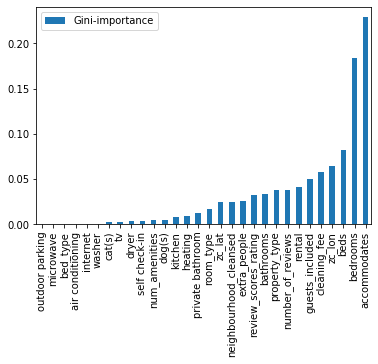

In [103]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, best_random.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
plt.show()

In [75]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
print('Average error also decreased by ' + str(round(base_error - random_error, 2)))

Improvement of 9.41%.
Average error also decreased by 6.53


#### Gradient Boosting

In [78]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                }
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [79]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gbr_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [80]:
gbr_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 110}

n_estaimtors: 400

min_samples_split: 10

min_samples_leaf: 4

max_features: sqrt

max_depth: 110

In [81]:
base_model = GradientBoostingRegressor(n_estimators = 100, random_state = 123)
base_model.fit(X_train, y_train)
base_accuracy, base_error = evaluate(base_model, X_val, y_val)

Model Performance
Average Error: 76.3068 dollars.
Accuracy = 58.91%.


In [84]:
best_random = gbr_random.best_estimator_
random_accuracy, random_error = evaluate(best_random, X_val, y_val)

Model Performance
Average Error: 71.1395 dollars.
Accuracy = 65.22%.


0.5992341157336452

In [83]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
print('Average error also decreased by ' + str(round(base_error - random_error, 2)))

Improvement of 10.70%.
Average error also decreased by 5.17


The randomgrid search hyperparameter tuning yielded god results. Gradient Boosting Regressor had the best accuracy as well as average error so we will use it as the final model

### Rental Modeling

In [117]:
data = pd.read_csv('rental_final_dataset.csv')

Split the data into 60% train, 20% val, 20% test

In [118]:
X = data.drop(['rental'], axis=1)
y = data['rental']
np.random.seed(123)
X, X_test_rental, y, y_test_rental = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)
X_train_rental, X_val_rental, y_train_rental, y_val_rental = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

#### Linear Regression

In [119]:
lin_model_rental = LinearRegression().fit(X_train_rental, y_train_rental)
lin_rental_pred_train = lin_model_rental.predict(X_train_rental)
lin_rental_pred_val = lin_model_rental.predict(X_val_rental)

In [126]:
print('R2 Train: ' + str(lin_model_rental.score(X_train_rental, y_train_rental)))
print('R2 Val: ' + str(lin_model_rental.score(X_val_rental, y_val_rental)))
print('Train MAE: ' + str(mean_absolute_error(y_train, lin_rental_pred_train)))
print('Val MAE: ' + str(mean_absolute_error(y_val, lin_rental_pred_val)))

R2 Train: 0.5584911091950402
R2 Val: 0.5562029570901093
Train MAE: 4121.699999999964
Val MAE: 4118.4031994523475


#### Random Forest

In [127]:
rf_model_rental = RandomForestRegressor(n_estimators=100).fit(X_train_rental, y_train_rental)
rf_rental_pred_train = rf_model_rental.predict(X_train_rental)
rf_rental_pred_val = rf_model_rental.predict(X_val_rental)

In [128]:
print('R2 Train: ' + str(rf_model_rental.score(X_train_rental, y_train_rental)))
print('R2 Val: ' + str(rf_model_rental.score(X_val_rental, y_val_rental)))
print('Train MAE: ' + str(mean_absolute_error(y_train_rental, rf_rental_pred_train)))
print('Val MAE: ' + str(mean_absolute_error(y_val_rental, rf_rental_pred_val)))

R2 Train: 0.9999100989380726
R2 Val: 0.9996138610719213
Train MAE: 2.6539285714285725
Val MAE: 5.934642857142856


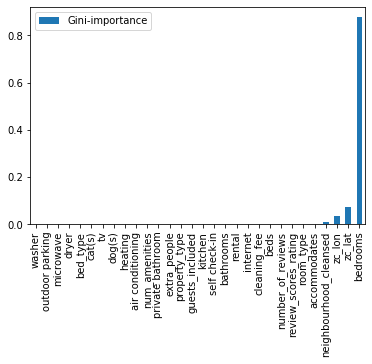

In [129]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, rf_model_rental.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
plt.show()

When predicting the rental prices for each unit, the random forest regressor did extremely well. This makes sense since the median rental price was given by just the number of bedrooms and zipcodes from the dataset.

### Comparative Analysis: To Airbnb or Rent?

In [130]:
gbr_model_airbnb = best_random

In [133]:
X_test.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,neighbourhood_cleansed,cleaning_fee,guests_included,...,heating,internet,kitchen,microwave,outdoor parking,private bathroom,self check-in,tv,washer,wifi
684,1,0,6,1,3,3,4,8,200,5,...,1,1,1,1,0,0,0,1,1,1
968,6,0,2,1,1,1,4,18,214,1,...,1,1,1,0,0,0,0,1,1,1
1387,1,0,6,2,4,4,4,17,220,4,...,1,1,1,0,0,0,1,1,1,1
275,1,2,1,1,1,1,4,1,50,1,...,1,1,1,0,0,0,0,0,1,1
221,12,2,2,1,1,1,4,12,50,1,...,1,1,1,0,0,0,1,0,1,1


In [134]:
X_test_rental.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,neighbourhood_cleansed,cleaning_fee,guests_included,...,heating,internet,kitchen,microwave,outdoor parking,private bathroom,self check-in,tv,washer,wifi
684,1,0,6,1,3,3,4,8,200,5,...,1,1,1,1,0,0,0,1,1,1
968,6,0,2,1,1,1,4,18,214,1,...,1,1,1,0,0,0,0,1,1,1
1387,1,0,6,2,4,4,4,17,220,4,...,1,1,1,0,0,0,1,1,1,1
275,1,2,1,1,1,1,4,1,50,1,...,1,1,1,0,0,0,0,0,1,1
221,12,2,2,1,1,1,4,12,50,1,...,1,1,1,0,0,0,1,0,1,1


In [144]:
airbnb_predicted = gbr_model_airbnb.predict(X_test)
airbnb_monthly_predicted = airbnb_predicted * 30
rental_predicted = rf_model_rental.predict(X_test)

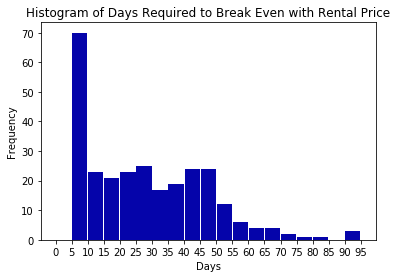

In [177]:
df = pd.DataFrame(pd.Series(np.round(rental_predicted / airbnb_predicted)))
n, bins, patches = plt.hist(x=df[0], bins=np.arange(0,100,5),rwidth=0.95, color='#0504aa')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram of Days Required to Break Even with Rental Price')
plt.xticks(np.arange(0,100,5))
plt.show()